In [324]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, f1_score, precision_score
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

import warnings
# Ignore PerformanceWarnings specifically
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=Warning)  # Ignore Perform

In [325]:
file_path = "/kaggle/input/data-storm-6-0/sample_submission_storming_round.csv" 
sub = pd.read_csv(file_path)

In [326]:
file_path = "/kaggle/input/data-storm-6-0/train_storming_round.csv" 
train = pd.read_csv(file_path)
train

,row_id,agent_code,agent_age,agent_join_month,first_policy_sold_month,year_month,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,...,unique_quotations,unique_customers_last_7_days,unique_customers_last_15_days,unique_customers_last_21_days,unique_customers,new_policy_count,ANBP_value,net_income,number_of_policy_holders,number_of_cash_payment_policies
0,1,455ca878,45,2/1/2021,9/1/2023,1/1/2023,3,6,2,12,...,9,3,4,8,15,0,0,93313,30,162
1,2,c823ce77,48,4/1/2022,2/1/2024,1/1/2023,1,4,12,21,...,14,4,3,10,17,25,1071450,164804,0,175
2,3,62154055,53,5/1/2020,9/1/2023,1/1/2023,3,5,5,17,...,14,3,7,11,21,26,1601210,426690,84,78
3,4,c58bfa6e,44,7/1/2019,3/1/2022,1/1/2023,1,0,12,17,...,11,2,2,9,13,18,283230,47793,39,144
4,5,b1e5f770,20,9/1/2020,2/1/2023,1/1/2023,0,6,10,17,...,13,3,10,6,19,20,1957680,562239,19,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15303,15304,d3b44e44,43,4/1/2019,10/1/2023,8/1/2024,1,6,6,17,...,10,3,4,11,18,25,2473900,404980,18,100
15304,15305,0b1d7054,28,9/1/2022,3/1/2024,8/1/2024,1,5,3,13,...,14,4,3,11,18,15,922050,198187,18,120
15305,15306,51321fa2,45,1/1/2021,4/1/2024,8/1/2024,0,6,17,26,...,22,6,7,6,19,30,645330,133263,57,270
15306,15307,dd4a0d2d,25,12/1/2021,12/1/2023,8/1/2024,0,4,6,14,...,13,6,3,6,15,0,0,32546,30,171


In [327]:
file_path = "/kaggle/input/data-storm-6-0/test_storming_round.csv" 
test = pd.read_csv(file_path)
test

,row_id,agent_code,agent_age,agent_join_month,first_policy_sold_month,year_month,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,...,unique_quotations,unique_customers_last_7_days,unique_customers_last_15_days,unique_customers_last_21_days,unique_customers,new_policy_count,ANBP_value,net_income,number_of_policy_holders,number_of_cash_payment_policies
0,1,de9a845f,43,6/1/2020,4/1/2022,9/1/2024,0,2,12,17,...,14,6,9,5,20,24,511320,86955,0,48
1,2,1450745b,32,5/1/2019,8/1/2022,9/1/2024,1,3,4,13,...,12,2,2,5,9,14,296660,55062,9,56
2,3,5c4dd08c,52,6/1/2019,6/1/2022,9/1/2024,2,6,17,27,...,21,5,6,10,21,34,833544,224429,0,34
3,4,3c7a8b50,21,5/1/2021,9/1/2023,9/1/2024,1,6,17,26,...,15,3,2,10,15,33,2972409,439159,15,33
4,5,3dd0c2a1,33,9/1/2022,11/1/2023,9/1/2024,0,4,2,8,...,14,5,4,6,15,15,168150,18195,60,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,910,8f77f8e4,55,5/1/2020,1/1/2022,9/1/2024,2,1,11,16,...,15,4,3,7,14,21,1143954,313127,14,21
910,911,a199082b,60,10/1/2021,11/1/2022,9/1/2024,2,1,15,21,...,19,2,4,2,8,26,2169310,267832,8,78
911,912,9c2e3be7,45,7/1/2022,7/1/2023,9/1/2024,3,5,14,27,...,23,3,2,10,15,34,1980194,449309,60,238
912,913,89cb3dd5,23,5/1/2021,6/1/2023,9/1/2024,3,5,7,19,...,10,3,7,3,13,28,2489004,462418,13,56


In [328]:
ids = test['row_id']
train = train.drop(columns=['row_id'], axis=1)
test = test.drop(columns=['row_id'], axis=1)

In [329]:
train = train.drop_duplicates()

In [330]:
def customDescription(df: pd.DataFrame, numeric_only: bool = False):
    if numeric_only:
        df = df.select_dtypes(include=np.number)
    
    desc = pd.DataFrame(index=df.columns.to_list())
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['null'] = df.isnull().sum()
    
    # Calculate mode and handle multiple modes
    modes = df.mode()
    desc['mode'] = np.nan  # Default to NaN
    for col in df.columns:
        if len(modes[col].dropna()) == 1:  # Single mode exists
            desc.loc[col, 'mode'] = modes[col].iloc[0]
        else:  # Multiple modes
            desc.loc[col, 'mode'] = np.nan

    # Calculate least frequent value
    desc['least_frequent'] = np.nan  # Default to NaN
    for col in df.columns:
        value_counts = df[col].value_counts(dropna=False)
        if not value_counts.empty:
            least_freq_count = value_counts.min()  # Find the minimum frequency
            least_freq_values = value_counts[value_counts == least_freq_count].index
            
            if len(least_freq_values) == 1:  # If exactly one least frequent value exists
                desc.loc[col, 'least_frequent'] = least_freq_values[0]
            else:  # Multiple least frequent values
                desc.loc[col, 'least_frequent'] = np.nan
    
    # Handle numeric columns
    numeric_cols = df.select_dtypes(include=np.number)
    if not numeric_cols.empty:
        numeric_desc = numeric_cols.describe().T.drop(columns=['count', 'std', '25%', '50%', '75%'], axis=1)
        for col in numeric_cols.columns:
            desc.loc[col, 'mean'] = numeric_desc.loc[col, 'mean']
            desc.loc[col, 'min'] = numeric_desc.loc[col, 'min']
            desc.loc[col, 'max'] = numeric_desc.loc[col, 'max']
    
    # Handle datetime columns
    datetime_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]'])
    for col in datetime_cols.columns:
        desc.loc[col, 'min'] = df[col].min()
        desc.loc[col, 'max'] = df[col].max()
    
    return desc

In [331]:
customDescription(train)

,type,count,nunique,null,mode,least_frequent,mean,min,max
agent_code,object,15308,905,0,NaN,NaN,NaN,NaN,NaN
agent_age,int64,15308,41,0,48.0,46.0,4.058577e+01,20.0,60.0
agent_join_month,object,15308,64,0,5/1/2019,7/1/2024,NaN,NaN,NaN
first_policy_sold_month,object,15308,28,0,4/1/2024,2/1/2022,NaN,NaN,NaN
year_month,object,15308,20,0,8/1/2024,1/1/2023,NaN,NaN,NaN
unique_proposals_last_7_days,int64,15308,4,0,0.0,3,1.491246e+00,0.0,3.0
unique_proposals_last_15_days,int64,15308,7,0,NaN,5,2.991116e+00,0.0,6.0
unique_proposals_last_21_days,int64,15308,21,0,11.0,6,1.004573e+01,0.0,20.0
unique_proposal,int64,15308,34,0,14.0,1,1.751653e+01,1.0,34.0
unique_quotations_last_7_days,int64,15308,5,0,0.0,2,1.989679e+00,0.0,4.0


In [332]:
customDescription(test)

,type,count,nunique,null,mode,least_frequent,mean,min,max
agent_code,object,914,914,0,NaN,NaN,NaN,NaN,NaN
agent_age,int64,914,41,0,NaN,46.0,4.050656e+01,20.0,60.0
agent_join_month,object,914,65,0,5/1/2019,1/1/2020,NaN,NaN,NaN
first_policy_sold_month,object,914,28,0,4/1/2024,2/1/2022,NaN,NaN,NaN
year_month,object,914,1,0,9/1/2024,9/1/2024,NaN,NaN,NaN
unique_proposals_last_7_days,int64,914,4,0,3.0,0,1.540481e+00,0.0,3.0
unique_proposals_last_15_days,int64,914,7,0,1.0,6,2.903720e+00,0.0,6.0
unique_proposals_last_21_days,int64,914,21,0,16.0,NaN,9.798687e+00,0.0,20.0
unique_proposal,int64,914,32,0,11.0,NaN,1.731838e+01,2.0,33.0
unique_quotations_last_7_days,int64,914,5,0,2.0,0,2.096280e+00,0.0,4.0


In [333]:
train['year_month'] = pd.to_datetime(train['year_month'], format='%m/%d/%Y')
test['year_month'] = pd.to_datetime(test['year_month'], format='%m/%d/%Y')
train['agent_join_month'] = pd.to_datetime(train['agent_join_month'], format='%m/%d/%Y')
test['agent_join_month'] = pd.to_datetime(test['agent_join_month'], format='%m/%d/%Y')
train['first_policy_sold_month'] = pd.to_datetime(train['first_policy_sold_month'], format='%m/%d/%Y')
test['first_policy_sold_month'] = pd.to_datetime(test['first_policy_sold_month'], format='%m/%d/%Y')

In [334]:
# Convert to sets
train_agents = set(train['agent_code'])
test_agents = set(test['agent_code'])

# Find missing and available agent codes
missing_agents = test_agents - train_agents
available_agents = test_agents & train_agents

# Print counts
print(f"Total agent_codes in test: {len(test_agents)}")
print(f"Available agent_codes (also in train): {len(available_agents)}")
print(f"Missing agent_codes (not in train): {len(missing_agents)}")
print(missing_agents)

Total agent_codes in test: 914
Available agent_codes (also in train): 905
Missing agent_codes (not in train): 9
{'f9f0169c', '6a0d02ea', '421aec8b', '335b4b20', 'b5338672', '5444f88c', 'c37f2ebf', 'd8e13589', '3f4c6d56'}


In [335]:
# merged_df = pd.concat([train, test], axis=0).reset_index(drop=True)

In [336]:
# agents_to_remove = {'f9f0169c', 'c37f2ebf', '421aec8b', '6a0d02ea', '5444f88c', '335b4b20', '3f4c6d56', 'b5338672', 'd8e13589'}
# merged_df = merged_df[~merged_df['agent_code'].isin(agents_to_remove)].reset_index(drop=True)
# merged_df

In [337]:
# train_sorted = merged_df.sort_values(by=['agent_code', 'year_month']).copy()
# train_sorted

In [338]:
train_sorted = train.sort_values(by=['agent_code', 'year_month']).copy()

In [339]:
train_shifted = train_sorted.copy()

In [340]:
train_shifted['next_month_new_policy_count'] = train_shifted.groupby('agent_code')['new_policy_count'].shift(-1)

In [341]:
# Group by agent_code and shift new_policy_count upward
# train_shifted['new_policy_count'] = train_shifted.groupby('agent_code')['new_policy_count'].shift(-1)

# Drop rows with NaN in new_policy_count (i.e., last row in each group)
# train_shifted = train_sorted.dropna(subset=['new_policy_count'])

In [342]:
# Identify the last row per agent_code group
last_rows = train_shifted.groupby('agent_code').tail(1)

# # Create test_shifted with those last rows
test_shifted = last_rows.copy()

# Remove those rows from train_shifted
train_shifted = train_shifted.drop(last_rows.index)

In [343]:
# test_shifted = test_shifted.drop(columns = ['new_policy_count'])

In [344]:
train_shifted['next_month_new_policy_count'] = (train_shifted['next_month_new_policy_count'] != 0).astype(int)
train_shifted

,agent_code,agent_age,agent_join_month,first_policy_sold_month,year_month,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,unique_quotations_last_7_days,...,unique_customers_last_7_days,unique_customers_last_15_days,unique_customers_last_21_days,unique_customers,new_policy_count,ANBP_value,net_income,number_of_policy_holders,number_of_cash_payment_policies,next_month_new_policy_count
8,003c1999,35,2020-08-01,2022-12-01,2023-01-01,2,2,0,8,0,...,2,2,1,5,0,0,327407,5,0,1
958,003c1999,35,2020-08-01,2022-12-01,2023-02-01,3,2,20,30,0,...,2,5,12,19,31,2408297,408662,57,217,1
1761,003c1999,35,2020-08-01,2022-12-01,2023-03-01,0,2,19,23,2,...,4,5,11,20,27,1901097,287226,20,243,1
2577,003c1999,35,2020-08-01,2022-12-01,2023-04-01,2,6,11,21,3,...,4,9,7,20,22,1635788,381203,60,176,1
2708,003c1999,35,2020-08-01,2022-12-01,2023-05-01,3,3,7,15,4,...,4,6,8,18,20,1876640,471548,0,180,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10661,fffb525d,32,2020-03-01,2023-11-01,2024-03-01,3,2,7,15,3,...,5,9,4,18,20,1953260,429008,36,60,1
10976,fffb525d,32,2020-03-01,2023-11-01,2024-04-01,2,6,7,17,1,...,1,9,9,19,25,557100,100780,57,75,1
12008,fffb525d,32,2020-03-01,2023-11-01,2024-05-01,0,6,12,23,0,...,1,4,6,11,29,1367553,316643,0,29,0
12950,fffb525d,32,2020-03-01,2023-11-01,2024-06-01,2,6,5,14,1,...,3,9,6,18,0,0,118609,54,184,1


In [345]:
train_shifted['new_policy_count'] = (train_shifted['new_policy_count'] != 0).astype(int)
test_shifted['new_policy_count'] = (test_shifted['new_policy_count'] != 0).astype(int)

In [346]:
test_shifted

,agent_code,agent_age,agent_join_month,first_policy_sold_month,year_month,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,unique_quotations_last_7_days,...,unique_customers_last_7_days,unique_customers_last_15_days,unique_customers_last_21_days,unique_customers,new_policy_count,ANBP_value,net_income,number_of_policy_holders,number_of_cash_payment_policies,next_month_new_policy_count
14467,003c1999,35,2020-08-01,2022-12-01,2024-08-01,0,2,7,11,4,...,5,4,9,18,1,1431460,371189,54,76,NaN
14852,00d5bda3,48,2019-08-01,2023-03-01,2024-08-01,2,1,1,5,4,...,4,3,8,15,0,0,33388,15,54,NaN
14676,012a3553,25,2019-05-01,2023-10-01,2024-08-01,0,3,20,26,3,...,3,3,12,18,1,1710996,215739,0,140,NaN
14850,012f0e15,31,2019-06-01,2024-04-01,2024-08-01,3,5,17,29,1,...,2,5,8,15,1,2006695,314659,15,222,NaN
15229,0177ed5f,46,2022-07-01,2023-08-01,2024-08-01,0,6,11,21,0,...,2,0,1,3,1,451764,92691,6,216,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14922,ff8edcc9,56,2022-04-01,2023-04-01,2024-08-01,2,4,3,11,1,...,1,8,7,16,1,1260464,282572,48,112,NaN
14461,ff955d18,54,2024-06-01,2024-04-01,2024-08-01,0,6,14,25,0,...,0,3,14,17,0,0,38245,68,0,NaN
14445,ffca3177,52,2021-07-01,2022-05-01,2024-08-01,3,1,18,25,4,...,6,6,7,19,1,2822271,322923,57,186,NaN
14545,ffe6c9e9,54,2019-08-01,2023-11-01,2024-08-01,2,1,5,9,3,...,3,6,2,11,1,597006,78550,44,85,NaN


In [347]:
# Create mapping DataFrame
agent_policy_map = test[['agent_code', 'new_policy_count']].copy()

# Rename column before merge
agent_policy_map.rename(columns={'new_policy_count': 'next_month_new_policy_count'}, inplace=True)

# Merge into test_shifted
test_shifted = test_shifted.drop(columns = ['next_month_new_policy_count'])
test_shifted = test_shifted.merge(agent_policy_map, on='agent_code', how='left')

In [348]:
test_shifted

,agent_code,agent_age,agent_join_month,first_policy_sold_month,year_month,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,unique_quotations_last_7_days,...,unique_customers_last_7_days,unique_customers_last_15_days,unique_customers_last_21_days,unique_customers,new_policy_count,ANBP_value,net_income,number_of_policy_holders,number_of_cash_payment_policies,next_month_new_policy_count
0,003c1999,35,2020-08-01,2022-12-01,2024-08-01,0,2,7,11,4,...,5,4,9,18,1,1431460,371189,54,76,27
1,00d5bda3,48,2019-08-01,2023-03-01,2024-08-01,2,1,1,5,4,...,4,3,8,15,0,0,33388,15,54,14
2,012a3553,25,2019-05-01,2023-10-01,2024-08-01,0,3,20,26,3,...,3,3,12,18,1,1710996,215739,0,140,27
3,012f0e15,31,2019-06-01,2024-04-01,2024-08-01,3,5,17,29,1,...,2,5,8,15,1,2006695,314659,15,222,16
4,0177ed5f,46,2022-07-01,2023-08-01,2024-08-01,0,6,11,21,0,...,2,0,1,3,1,451764,92691,6,216,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,ff8edcc9,56,2022-04-01,2023-04-01,2024-08-01,2,4,3,11,1,...,1,8,7,16,1,1260464,282572,48,112,22
901,ff955d18,54,2024-06-01,2024-04-01,2024-08-01,0,6,14,25,0,...,0,3,14,17,0,0,38245,68,0,14
902,ffca3177,52,2021-07-01,2022-05-01,2024-08-01,3,1,18,25,4,...,6,6,7,19,1,2822271,322923,57,186,30
903,ffe6c9e9,54,2019-08-01,2023-11-01,2024-08-01,2,1,5,9,3,...,3,6,2,11,1,597006,78550,44,85,16


In [349]:
test_shifted['next_month_new_policy_count'] = (test_shifted['next_month_new_policy_count'] != 0).astype(int)
test_shifted

,agent_code,agent_age,agent_join_month,first_policy_sold_month,year_month,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,unique_quotations_last_7_days,...,unique_customers_last_7_days,unique_customers_last_15_days,unique_customers_last_21_days,unique_customers,new_policy_count,ANBP_value,net_income,number_of_policy_holders,number_of_cash_payment_policies,next_month_new_policy_count
0,003c1999,35,2020-08-01,2022-12-01,2024-08-01,0,2,7,11,4,...,5,4,9,18,1,1431460,371189,54,76,1
1,00d5bda3,48,2019-08-01,2023-03-01,2024-08-01,2,1,1,5,4,...,4,3,8,15,0,0,33388,15,54,1
2,012a3553,25,2019-05-01,2023-10-01,2024-08-01,0,3,20,26,3,...,3,3,12,18,1,1710996,215739,0,140,1
3,012f0e15,31,2019-06-01,2024-04-01,2024-08-01,3,5,17,29,1,...,2,5,8,15,1,2006695,314659,15,222,1
4,0177ed5f,46,2022-07-01,2023-08-01,2024-08-01,0,6,11,21,0,...,2,0,1,3,1,451764,92691,6,216,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,ff8edcc9,56,2022-04-01,2023-04-01,2024-08-01,2,4,3,11,1,...,1,8,7,16,1,1260464,282572,48,112,1
901,ff955d18,54,2024-06-01,2024-04-01,2024-08-01,0,6,14,25,0,...,0,3,14,17,0,0,38245,68,0,1
902,ffca3177,52,2021-07-01,2022-05-01,2024-08-01,3,1,18,25,4,...,6,6,7,19,1,2822271,322923,57,186,1
903,ffe6c9e9,54,2019-08-01,2023-11-01,2024-08-01,2,1,5,9,3,...,3,6,2,11,1,597006,78550,44,85,1


In [350]:
train_shifted['proposals_trend'] = train_shifted['unique_proposals_last_7_days'] - train_shifted['unique_proposals_last_15_days']
train_shifted['quotations_trend'] = train_shifted['unique_quotations_last_7_days'] - train_shifted['unique_quotations_last_15_days']
train_shifted['customers_trend'] = train_shifted['unique_customers_last_7_days'] - train_shifted['unique_customers_last_15_days']

In [351]:
test_shifted['proposals_trend'] = test_shifted['unique_proposals_last_7_days'] - test_shifted['unique_proposals_last_15_days']
test_shifted['quotations_trend'] = test_shifted['unique_quotations_last_7_days'] - test_shifted['unique_quotations_last_15_days']
test_shifted['customers_trend'] = test_shifted['unique_customers_last_7_days'] - test_shifted['unique_customers_last_15_days']

In [352]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train_shifted['agent_code'] = le.fit_transform(train_shifted['agent_code'])

In [353]:
# Create a mapping dictionary
label_map = dict(zip(le.classes_, le.transform(le.classes_)))

# Apply the mapping to test data, assign -1 to unseen agent_codes
test_shifted['agent_code'] = test_shifted['agent_code'].map(label_map).fillna(-1).astype(int)

In [354]:
train_shifted['agent_join_year'] = train_shifted['agent_join_month'].dt.year
train_shifted['agent_join_month_num'] = train_shifted['agent_join_month'].dt.month

train_shifted['first_policy_sold_year'] = train_shifted['first_policy_sold_month'].dt.year
train_shifted['first_policy_sold_month_num'] = train_shifted['first_policy_sold_month'].dt.month

train_shifted['year'] = train_shifted['year_month'].dt.year
train_shifted['month'] = train_shifted['year_month'].dt.month

# Drop original datetime columns
train_shifted = train_shifted.drop(columns=['agent_join_month', 'first_policy_sold_month', 'year_month'])

In [355]:
test_shifted['agent_join_year'] = test_shifted['agent_join_month'].dt.year
test_shifted['agent_join_month_num'] = test_shifted['agent_join_month'].dt.month

test_shifted['first_policy_sold_year'] = test_shifted['first_policy_sold_month'].dt.year
test_shifted['first_policy_sold_month_num'] = test_shifted['first_policy_sold_month'].dt.month

test_shifted['year'] = test_shifted['year_month'].dt.year
test_shifted['month'] = test_shifted['year_month'].dt.month

# Drop original datetime columns
test_shifted = test_shifted.drop(columns=['agent_join_month', 'first_policy_sold_month', 'year_month'])

In [356]:
cols_to_normalize = [
    'unique_proposals_last_7_days',
    'unique_proposal',
    'unique_quotations_last_7_days',
    'unique_quotations',
    'unique_customers_last_7_days',
    'unique_customers',
    'number_of_cash_payment_policies',
    'number_of_policy_holders',
    'net_income'
]

# Group by year and month, calculate sum for each group
group_cols = ['year', 'month']
grouped_sum = train_shifted.groupby(group_cols)[cols_to_normalize].transform('sum')

# Divide each value by the total in its (year, month) group
for col in cols_to_normalize:
    train_shifted[col + '_proportion'] = train_shifted[col] / grouped_sum[col]

In [357]:
cols_to_normalize = [
    'unique_proposals_last_7_days',
    'unique_proposal',
    'unique_quotations_last_7_days',
    'unique_quotations',
    'unique_customers_last_7_days',
    'unique_customers',
    'number_of_cash_payment_policies',
    'number_of_policy_holders',
    'net_income'
]

# Group by year and month, calculate sum for each group
group_cols = ['year', 'month']
grouped_sum = test_shifted.groupby(group_cols)[cols_to_normalize].transform('sum')

# Divide each value by the total in its (year, month) group
for col in cols_to_normalize:
    test_shifted[col + '_proportion'] = test_shifted[col] / grouped_sum[col]

In [358]:
agents_with_all_ones = (
    train_shifted.groupby('agent_code')['next_month_new_policy_count']
    .apply(lambda x: (x == 1).all())
)

# Filter only those agents
agents_with_all_ones = agents_with_all_ones[agents_with_all_ones].index.tolist()
agents_with_all_ones = set(agents_with_all_ones)
len(agents_with_all_ones)

200

In [359]:
train_shifted['past_nill'] = train_shifted['agent_code'].isin(agents_with_all_ones).astype(int)

In [360]:
# Extract agent_code and past_nill mapping from train_shifted (drop duplicates to avoid multiple matches)
past_nill_map = train_shifted[['agent_code', 'past_nill']].drop_duplicates()

# Merge into test_shifted
test_shifted = test_shifted.merge(past_nill_map, on='agent_code', how='left')

In [361]:
test_shifted['past_nill'] = test_shifted['past_nill'].fillna(1)

In [362]:
train_shifted['join_duration'] = (train_shifted['year'] - train_shifted['agent_join_year'])*12 + (train_shifted['month'] - train_shifted['agent_join_month_num'])
train_shifted['time_to_sell'] = (train_shifted['first_policy_sold_year'] - train_shifted['agent_join_year'])*12 + (train_shifted['first_policy_sold_month_num'] - train_shifted['agent_join_month_num'])

In [363]:
test_shifted['join_duration'] = (test_shifted['year'] - test_shifted['agent_join_year'])*12 + (test_shifted['month'] - test_shifted['agent_join_month_num'])
test_shifted['time_to_sell'] = (test_shifted['first_policy_sold_year'] - test_shifted['agent_join_year'])*12 + (test_shifted['first_policy_sold_month_num'] - test_shifted['agent_join_month_num'])

In [364]:
top_columns = [
    'net_income',
    'ANBP_value',
    'agent_code',
    'number_of_cash_payment_policies',
    'past_nill',
    'new_policy_count',
    'month',
    'unique_quotations_proportion',
    'unique_proposals_last_21_days',
    'unique_proposal_proportion',
]

# Keep only those columns in your train and test sets
train_shifted = train_shifted[top_columns + ['next_month_new_policy_count']] 
test_shifted = test_shifted[top_columns + ['next_month_new_policy_count']] 

In [365]:
import numpy as np
import pandas as pd
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, f1_score, precision_score

In [366]:
def get_model_predictions(X, y, df_test, model_func, params):
    test_preds = np.zeros(len(df_test))
    val_preds = np.zeros(len(X))
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=9)

    for fold, (train_ind, valid_ind) in enumerate(cv.split(X, y)):
        X_train, y_train = X.iloc[train_ind], y[train_ind]
        X_val, y_val = X.iloc[valid_ind], y[valid_ind]

        model = model_func(**params)
        if(model_func == lgb_model):
            model.fit(X_train, y_train,
                       eval_set=[(X_val, y_val)],
                       callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)])
        elif(model_func == xgb_model):
            model.fit(X_train, y_train,
                      eval_set=[(X_val, y_val)],
                      verbose=False) 
        else:
            model.fit(X_train, y_train,
                      cat_features=[7, 8, 9],
                      eval_set=[(X_val, y_val)],
                      early_stopping_rounds=50,
                      verbose=False)    
        gc.collect()
        # Predictions
        y_pred_trn = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        train_f1 = np.round(f1_score(y_train, y_pred_trn) * 100, 2)
        val_f1 = np.round(f1_score(y_val, y_pred_val) * 100, 2)
        
        print("-" * 50)
        print(model_func, "Fold:", fold, " Train F1:", np.round(train_f1, 5), " Val F1:", np.round(val_f1, 5))
        print("-" * 50)
        
        val_preds[valid_ind] = y_pred_val
        test_preds += model.predict(df_test) / cv.n_splits
        gc.collect()
        
    return val_preds, test_preds

In [367]:
def lgb_model(**params):
    return lgb.LGBMClassifier(**params)

def xgb_model(**params):
    return XGBClassifier(**params)

def catb_model(**params):
    return CatBoostClassifier(**params)

In [368]:
categorical_cols = ['past_nill', 'month', 'new_policy_count']

for col in categorical_cols:
    train_shifted[col] = train_shifted[col].astype(int).astype('category')
    test_shifted[col] = test_shifted[col].astype(int).astype('category')

In [369]:
label = 'next_month_new_policy_count' 
X = train_shifted.drop(columns=[label], axis=1)  
y = train_shifted[label]

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [370]:
test_ = test_shifted.drop(columns=[label], axis=1)  
results_ = test_shifted[label]

test_ = test_.reset_index(drop=True)
results_ = results_.reset_index(drop=True)

In [371]:
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'device': 'gpu',
    'verbose':-1
}

xgb_params = {
    'tree_method': 'gpu_hist',
    'device': 'gpu',
    'enable_categorical':True,
    'scale_pos_weight': (y == 0).sum() / (y == 1).sum()

}


catboost_params = {
    'grow_policy': 'SymmetricTree',
    'loss_function': 'Logloss',
    'eval_metric': 'Accuracy',  
    'task_type': 'GPU'
}

In [372]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define categorical columns
categorical_cols = ['past_nill', 'month', 'new_policy_count']

# Separate numerical and categorical columns
X_num = X.drop(columns=categorical_cols)
X_cat = X[categorical_cols]

test_num = test_.drop(columns=categorical_cols)
test_cat = test_[categorical_cols]

# Scale only the numerical features
scaler = StandardScaler()
X_scaled_num = pd.DataFrame(scaler.fit_transform(X_num), columns=X_num.columns, index=X.index)
test_scaled_num = pd.DataFrame(scaler.transform(test_num), columns=test_num.columns, index=test_.index)

# Concatenate scaled numerical features with original categorical features
X_scaled = pd.concat([X_scaled_num, X_cat], axis=1)
test_scaled = pd.concat([test_scaled_num, test_cat], axis=1)

In [378]:
print("1. LGBMClassifier")
lgb_val_preds, lgb_test_preds = get_model_predictions(X_scaled, y, test_scaled, lgb_model,lgb_params)
print("2. XGBClassifier")
xgb_val_preds, xgb_test_preds = get_model_predictions(X_scaled, y, test_scaled, xgb_model,xgb_params)
print("3. CatBoostClassifier")
catb_val_preds, catb_test_preds = get_model_predictions(X_scaled, y, test_scaled, catb_model,catboost_params)

1. LGBMClassifier
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_error: 0.0999306
--------------------------------------------------
<function lgb_model at 0x7de548b20b80> Fold: 0  Train F1: 94.76  Val F1: 94.74
--------------------------------------------------
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_error: 0.0999306
--------------------------------------------------
<function lgb_model at 0x7de548b20b80> Fold: 1  Train F1: 94.76  Val F1: 94.74
--------------------------------------------------
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_error: 0.0999306
--------------------------------------------------
<function lgb_model at 0x7de548b20b80> Fold: 2  Train F1: 94.76  Val F1: 94.74
--------------------------------------------------
Training until validation scores don'

In [379]:
import numpy as np

xgb_test_preds_ = np.where(xgb_test_preds < 0.6, 0, 1)
catb_test_preds_ = np.where(catb_test_preds < 0.6, 0, 1)
lgb_test_preds_ = np.where(lgb_test_preds < 0.6, 0, 1)

--------------------------------------------------
********************
Validation MCC       : 0.01008
Validation Recall    : 82.12 %
Validation F1 Score  : 85.77 %
Validation Precision : 89.76 %
********************


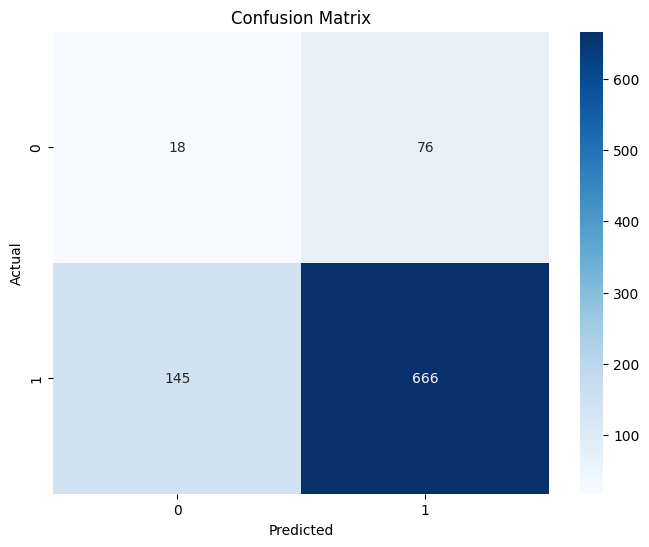

--------------------------------------------------


In [380]:
from sklearn.metrics import matthews_corrcoef, accuracy_score

# Calculate and print metrics on the validation set on LGBM
mcc = np.round(matthews_corrcoef(results_, xgb_test_preds_), 5)
recall = np.round(recall_score(results_, xgb_test_preds_) * 100, 2)
f1 = np.round(f1_score(results_, xgb_test_preds_) * 100, 2)
precision = np.round(precision_score(results_, xgb_test_preds_) * 100, 2)
print("-" * 50)

print('*' * 20)
print('Validation MCC       :', mcc)
print('Validation Recall    :', recall, '%')
print('Validation F1 Score  :', f1, '%')
print('Validation Precision :', precision, '%')
print('*' * 20)

# Draw the confusion matrix
cm = confusion_matrix(results_, xgb_test_preds_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
gc.collect()

print("-" * 50)

# ********************
# Validation MCC       : 0.12262
# Validation Recall    : 99.51 %
# Validation F1 Score  : 94.5 %
# Validation Precision : 89.97 %
# ********************

--------------------------------------------------
********************
Validation MCC       : 0.0
Validation Recall    : 100.0 %
Validation F1 Score  : 94.52 %
Validation Precision : 89.61 %
********************


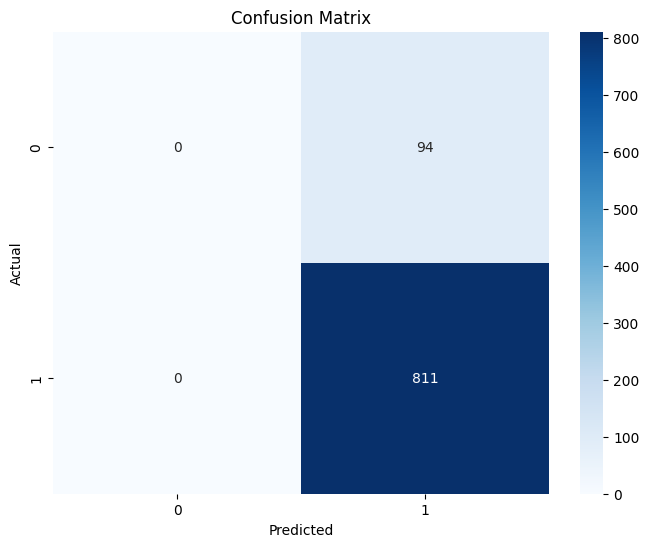

--------------------------------------------------


In [381]:
from sklearn.metrics import matthews_corrcoef, accuracy_score

# Calculate and print metrics on the validation set on LGBM
mcc = np.round(matthews_corrcoef(results_, catb_test_preds_), 5)
recall = np.round(recall_score(results_, catb_test_preds_) * 100, 2)
f1 = np.round(f1_score(results_, catb_test_preds_) * 100, 2)
precision = np.round(precision_score(results_, catb_test_preds_) * 100, 2)
print("-" * 50)

print('*' * 20)
print('Validation MCC       :', mcc)
print('Validation Recall    :', recall, '%')
print('Validation F1 Score  :', f1, '%')
print('Validation Precision :', precision, '%')
print('*' * 20)

# Draw the confusion matrix
cm = confusion_matrix(results_, catb_test_preds_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
gc.collect()

print("-" * 50)

# ********************
# Validation MCC       : 0.0
# Validation Recall    : 100.0 %
# Validation F1 Score  : 94.52 %
# Validation Precision : 89.61 %
# ********************

--------------------------------------------------
********************
Validation MCC       : 0.0
Validation Recall    : 100.0 %
Validation F1 Score  : 94.52 %
Validation Precision : 89.61 %
********************


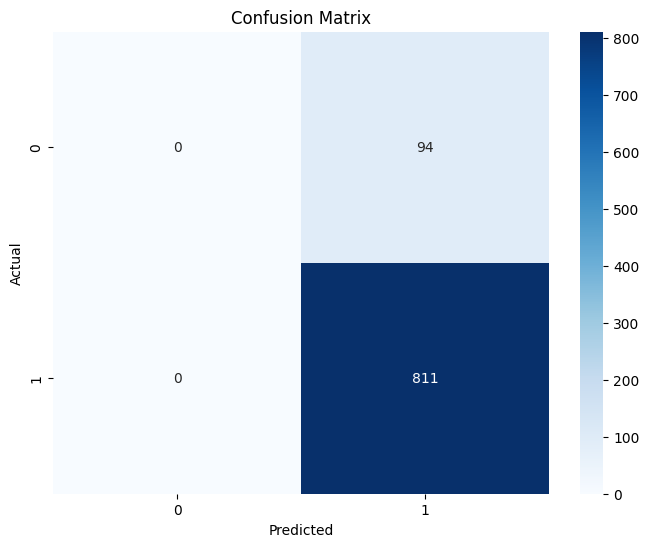

--------------------------------------------------


In [382]:
from sklearn.metrics import matthews_corrcoef, accuracy_score

# Calculate and print metrics on the validation set on LGBM
mcc = np.round(matthews_corrcoef(results_, lgb_test_preds_), 5)
recall = np.round(recall_score(results_, lgb_test_preds_) * 100, 2)
f1 = np.round(f1_score(results_, lgb_test_preds_) * 100, 2)
precision = np.round(precision_score(results_, lgb_test_preds_) * 100, 2)
print("-" * 50)

print('*' * 20)
print('Validation MCC       :', mcc)
print('Validation Recall    :', recall, '%')
print('Validation F1 Score  :', f1, '%')
print('Validation Precision :', precision, '%')
print('*' * 20)

# Draw the confusion matrix
cm = confusion_matrix(results_, lgb_test_preds_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
gc.collect()

print("-" * 50)

# ********************
# Validation MCC       : 0.0
# Validation Recall    : 100.0 %
# Validation F1 Score  : 94.52 %
# Validation Precision : 89.61 %
# ********************